
<div><h1><b> Issue Topic Modeling</b> </h1>
</div>

# Preparation

Install external packages

In [ ]:
# !pip install PyGithub -q
!pip install tomotopy -q
!pip install pyldavis -q
!pip install wordcloud -q
# !pip install -U sentence-transformers -q

     |████████████████████████████████| 16.3 MB 6.8 MB/s 
     |████████████████████████████████| 1.7 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


Import required packages

In [ ]:
import pandas as pd
import sklearn 
import numpy as np
import tomotopy as tp
print(tp.isa) # prints 'avx2', 'avx', 'sse2' or 'none' # processing instruction set
import json
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm
from collections import Counter
import pyLDAvis
from wordcloud import WordCloud
import gensim
import os.path
# from sentence_transformers import SentenceTransformer
import urllib
import pickle

avx2
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Data

Keywords for bug issues

In [ ]:
selected_labels= ['bug', 'error', 'fix', 'issue', 'invalid', 'defect', 
                  #'compatibility', 'critical', 
                  'maintenance', 'debt', 'refactor']
#selected_labels = ['bug']
#selected_labels = None
is_labelled = True

In [ ]:
# np.any([l in 'ffbug' for l in selected_labels])

Connect to the disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/TOM"

Mounted at /content/drive


Read Issues

In [ ]:
issues_path = os.path.join(PATH, "issues", "issues.csv")

issues = pd.read_csv(issues_path)


issues.head()
issues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46986 entries, 0 to 46985
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46986 non-null  object 
 1   repository_url            46986 non-null  object 
 2   labels_url                46986 non-null  object 
 3   comments_url              46986 non-null  object 
 4   events_url                46986 non-null  object 
 5   html_url                  46986 non-null  object 
 6   id                        46986 non-null  int64  
 7   node_id                   46986 non-null  object 
 8   number                    46986 non-null  int64  
 9   title                     46986 non-null  object 
 10  user                      46986 non-null  object 
 11  labels                    46986 non-null  object 
 12  state                     46986 non-null  object 
 13  locked                    46986 non-null  bool   
 14  assign

In [ ]:
issues.shape

(46986, 29)

Identify labelled Issues

In [ ]:
if is_labelled:
  issues_labels = issues.labels.apply(json.loads).apply(lambda x: pd.Series(x, dtype=object))

  labelled = dict() 
  rows, columns = np.where(issues_labels.notnull())
 

  for i in range(len(rows)):
    label = issues_labels.iloc[rows[i],columns[i]]
    idx = rows[i]

    if pd.isna(label):
      continue 
     
    name = label['name'] 
    if selected_labels is None:
      pass
    elif not np.any([l in name.lower() for l in selected_labels]) : 
      continue
    
    if name in labelled: 
      labelled[name] = labelled[name] + [idx]
    else:
      labelled[name] = [idx]

NameError: ignored

All unlabeled issues

In [ ]:
unlabeled = list(np.where(np.all(issues_labels.isna(), axis = 1))[0])
labelled['UNLABELED'] = unlabeled

In [ ]:
if is_labelled:
  ids = [] 

  for k, v in labelled.items():
    ids = ids + v

# uncomment to select only labelled issues
# issues = issues.loc[ids]

`labelled` contains the indices of labelled issues in addition to UNLABELED issues 

`ids` only keeps the ids of `labelled` data

In [ ]:
issues['labels'].iloc[200]

'[{"id": 1244928144, "node_id": "MDU6TGFiZWwxMjQ0OTI4MTQ0", "url": "https://api.github.com/repos/kubernetes/committee-security-response/labels/lgtm", "name": "lgtm", "color": "15dd18", "default": false, "description": "Indicates that a PR is ready to be merged."}, {"id": 1244928841, "node_id": "MDU6TGFiZWwxMjQ0OTI4ODQx", "url": "https://api.github.com/repos/kubernetes/committee-security-response/labels/approved", "name": "approved", "color": "0ffa16", "default": false, "description": "Indicates a PR has been approved by an approver from all required OWNERS files."}, {"id": 1244933380, "node_id": "MDU6TGFiZWwxMjQ0OTMzMzgw", "url": "https://api.github.com/repos/kubernetes/committee-security-response/labels/size/XS", "name": "size/XS", "color": "009900", "default": false, "description": "Denotes a PR that changes 0-9 lines, ignoring generated files."}, {"id": 1244936201, "node_id": "MDU6TGFiZWwxMjQ0OTM2MjAx", "url": "https://api.github.com/repos/kubernetes/committee-security-response/labe

In [ ]:
issues.shape

(46986, 29)

In [ ]:
issues.to_csv(os.path.join(PATH, "issues_final.csv"))

Issue Labels from Github developers

[('enhancement', 1710),
 ('bug', 1124),
 ('question', 950),
 ('dependencies', 932),
 ('Pending', 820),
 ('JetEngine', 646),
 ('JetWooBuilder', 423),
 ('Ready for release', 367),
 ('Done', 349),
 ('help wanted', 309),
 ('cla: yes', 190),
 ('JetSmartFilters', 185),
 (':bug: bug', 182),
 ('JetElements', 167),
 (':sparkles: enhancement', 154),
 ('approved', 142),
 ('lgtm', 131),
 ('documentation', 108),
 ('committee/security-response', 103),
 ('cncf-cla: yes', 102),
 ('wontfix', 86),
 ('my-dojo', 82),
 ('size/XS', 79),
 ('invalid', 79),
 ('request', 79),
 ('feature', 75),
 ('JetReviews', 69),
 ('guidance', 69),
 ('JetMenu', 67),
 ('greenkeeper', 67),
 ('duplicate', 65),
 ('module/cog-id-provider', 65),
 ('good first issue', 62),
 ('stale', 62),
 ('Defect', 61),
 (':children_crossing: duplicate', 59),
 ('type: enhancement', 55),
 ('bug:unconfirmed', 50),
 ('feature-request', 47),
 (':no_good: invalid', 46),
 ('needs-review', 44),
 ('JetAppointment', 44),
 ('dco-signoff: yes', 42),
 ('support', 41),
 ('JetTricks', 41),
 ('response-requested', 41),
 ('JetCompareWishlist', 39),
 ('JetSearch', 39),
 ('compatibility', 39),
 ('JetTabs', 38),
 ('JetBlog', 38),
 ('FDE', 38),
 ('p1 - backlog', 37),
 ('bug:confirmed', 37),
 ('Added to backlog', 36),
 ('JetProductGallery', 36),
 ('team:security engineering', 36),
 ('JetPopup', 35),
 ('mvr', 35),
 ('CLA Signed', 34),
 ('p0 - critical', 33),
 ('JetBlocks', 33),
 ('docs', 32),
 ('Feature', 31),
 (':information_source:  tooltips', 31),
 ('scale:tiny', 30),
 ('closed-for-staleness', 29),
 ('size/S', 28),
 ('JetBooking', 28),
 ('static analysis', 26),
 ('autogenerated', 26),
 ('In work', 26),
 ('maintenance', 26),
 ('lifecycle/rotten', 25),
 ('application: granted', 25),
 ('rules', 25),
 ('ux', 24),
 ('Debt', 24),
 ('type: bug', 23),
 ('new feature', 22),
 ('security', 22),
 ('jira', 22),
 (':moneybag:  guild bank', 21),
 ('Team Scytale', 21),
 ('housekeeping', 21),
 ('refactor', 21),
 ('size/M', 20),
 (':construction: conflict', 20),
 ('new_device', 20),
 ('internal', 20),
 ('Hacktoberfest', 19),
 ('high priority', 19),
 ('size/L', 18),
 ('Features', 18),
 ('test', 18),
 ('dependency', 18),
 ('javascript', 18),
 ('low priority', 17),
 ('api-feedback', 17),
 ('dip-addition', 17),
 ('Foundation', 16),
 ('Bugs', 16),
 ('type: breaking change', 16),
 ('prio-4', 15),
 ('type: question', 15),
 ('Enhancement', 15),
 ('feedback-needed', 15),
 ('purs-0.15', 15),
 ('awaiting-feedback', 15),
 (':spaghetti: blizzard bug', 14),
 ('Android', 14),
 ('backported', 14),
 ('backport-11.3', 14),
 ('beta release', 14),
 ('dip-tweaks', 14),
 ('not a bug', 14),
 ('Team Hyper Flow', 14),
 ('Unplanned', 14),
 ('High-Priority', 13),
 ('Fixed - Needs revision/tests', 13),
 ('feature request', 13),
 ('todo', 13),
 ('scale:medium', 13),
 ('tool-sharpening', 13),
 ('needs investigation', 13),
 ('software delivery performance', 13),
 ('needs-rebase', 12),
 ('mid priority', 12),
 (':jeans: wildpants', 12),
 ('dynamic analysis', 12),
 ('build', 12),
 ('up-for-grabs', 12),
 ('JetThemeCore', 12),
 ('1', 12),
 ('needs more info', 12),
 ('Swift', 11),
 ('question / help', 11),
 ('new DIP', 11),
 ('new-bug', 11),
 ('status/accepted', 11),
 ('high', 11),
 ('feedback', 11),
 ('failure-exporter', 11),
 ('Size Small', 11),
 ('discussion', 11),
 ('docker', 11),
 ('lifecycle/frozen', 10),
 ('non issue', 10),
 ('Bug', 10),
 ('pending-response', 10),
 ('widget request', 10),
 ('to review', 10),
 ('ARCHIVED - http://mzl.la/ghe-archive', 10),
 ('RFC', 10),
 ('Debugging', 10),
 ('Size Medium', 10),
 ('Priority 3', 10),
 ('Unconfirmed', 9),
 ('fix', 9),
 ('infra', 9),
 ('type: documentation', 9),
 (':scroll: sorting', 9),
 (':eyeglasses: search', 9),
 (':hole:  void storage', 9),
 (':dollar: bank', 9),
 ('performance', 9),
 ('status: confirmed', 9),
 ('p2 - icebox', 9),
 ('training', 9),
 ('Team Carbon-11', 9),
 ('cleanup', 9),
 ('coding debt', 9),
 ('design', 9),
 ('ci', 9),
 ('iOS', 8),
 ('breaking changes', 8),
 ('priority: high', 8),
 ('cla: no', 8),
 ('Good idea!', 8),
 ('source request', 8),
 ('Feature requests', 8),
 ('help-wanted', 8),
 ('investigate', 8),
 ('kind/question', 8),
 ('mvr_nice_to_have', 8),
 ('Priority 1', 8),
 ('New Page', 7),
 ('user-submitted-issue', 7),
 ('Feedback', 7),
 ('Documentation', 7),
 ('priority: low', 7),
 ('JetFormBuilder', 7),
 ('investigating', 7),
 ('breaking', 7),
 ('meta', 7),
 ('bugs', 7),
 ('status/needs-attention', 7),
 ('feature debt', 7),
 ('Size Large', 7),
 ('Has dependency', 6),
 ('prio-3', 6),
 ('issue', 6),
 ('more-information-needed', 6),
 ('policies', 6),
 ('closing-soon', 6),
 ('type: bug 🐛', 6),
 ('first-timers-only', 6),
 ('on-hold', 6),
 ('new-feature-request', 6),
 ('semver: Patch', 6),
 ('fixed', 6),
 ('kind/enhancement', 6),
 ('kind/bug', 6),
 ('low', 6),
 ('committime-exporter', 6),
 ('workaround_found', 5),
 ('TODO', 5),
 ('maintenance tool', 5),
 ('work in progress', 5),
 ('important', 5),
 ('can not reproduce yet', 5),
 ('source: hooli', 5),
 ("can't fix", 5),
 ('need feedback', 5),
 ('needs-reproduction', 5),
 ('external contribution', 5),
 ('status: Approved', 5),
 ('resolved', 5),
 ('Feature Request', 5),
 ('Priority 2', 5),
 ('python', 5),
 ('examples', 5),
 ('triage/accepted', 4),
 ('prio-1', 4),
 ('in-progress', 4),
 ('testing', 4),
 ('patch', 4),
 ('closing-soon-if-no-response', 4),
 ('Linux', 4),
 ('team', 4),
 ('good-first-bug', 4),
 ('no-time-tracked', 4),
 ('backport-12.0', 4),
 ('needs-more-input', 4),
 ('needs-ok-to-test', 4),
 ('Command Line Tool', 4),
 ('work-in-progress', 4),
 ('confusing-error', 4),
 ('features', 4),
 ('orbtoberfest', 4),
 ('hacktoberfest', 4),
 ('タスク', 4),
 ('type: Chore', 4),
 ('type: Documentation', 4),
 ('type: Bug', 4),
 ('type: Feature', 4),
 ('scale:large', 4),
 ('to test', 4),
 ('unsupported model', 4),
 ('do-not-merge/work-in-progress', 4),
 ('do-not-merge/hold', 3),
 ('sig/security', 3),
 ('Design Decision Needed', 3),
 ('hacktoberfest-accepted', 3),
 ('refactoring', 3),
 ('ops', 3),
 ('maybe-wont-do', 3),
 ('UI', 3),
 ('high-prio', 3),
 ('needs tests', 3),
 ('dev env', 3),
 ('build tool: stack', 3),
 ('improvement', 3),
 ('OpenCL 2.0', 3),
 ('no sscce', 3),
 ('RFP', 3),
 ('application: review', 3),
 ('Answered', 3),
 ('priority: medium', 3),
 ('type: feature request', 3),
 ('status: duplicate', 3),
 ('in_work', 3),
 ('JetStyleManager', 3),
 ('accessibility', 3),
 ('status - feedback', 3),
 ('abandoned', 3),
 ('need verification', 3),
 ('topic:c', 3),
 ('ok-to-test', 3),
 ('pending changes', 3),
 ('assigned(WIP)', 3),
 ('last fix(ready for merge)', 3),
 ('new resources', 3),
 ('team:core infra', 3),
 ('awaiting-fix-release', 3),
 ('A', 3),
 ('queued', 3),
 ('C', 3),
 ('blocked', 3),
 ('stage: needs more info', 3),
 ('Python 3', 3),
 ('2', 3),
 ('area/usability', 3),
 ('status/more-info-needed', 3),
 ('unable to reproduce', 3),
 ('Question', 3),
 ('new backend', 3),
 ('deploytime-exporter', 3),
 ('ocp_4.7', 3),
 ('tracking issue', 3),
 ('github_actions', 3),
 ('fixed for release', 3),
 ('lifecycle/stale', 2),
 ('cncf-cla: no', 2),
 ('size/XL', 2),
 ('release', 2),
 ('prio-5', 2),
 ('prio-2', 2),
 ('sec', 2),
 ('info-needed', 2),
 ('can-workaround', 2),
 ('needs-additional-reviewer', 2),
 ('ready-to-merge', 2),
 ('ui/ux', 2),
 ('Blocked', 2),
 ('Fixed', 2),
 ('elastic stack 5.0', 2),
 ('UWP', 2),
 ('waiting on changes', 2),
 ('ionitron:closed', 2),
 ('status: wont do/fix', 2),
 ('incomplete', 2),
 ('wishlist', 2),
 ('waiting for feedback', 2),
 ('backport-11.2', 2),
 ('review', 2),
 ('Acknowledged', 2),
 ('DevTools Plugin', 2),
 ('UPD Documentation', 2),
 ('JetParallax', 2),
 ('development', 2),
 ('potential-bug', 2),
 ('ui/ ux :eyes:', 2),
 ('suggestion', 2),
 ('p1', 2),
 ('p0', 2),
 ('status: blocked', 2),
 ('needs-triage', 2),
 ('B', 2),
 ('stage: awaiting external fix', 2),
 ('Support', 2),
 ('Team Sphinx', 2),
 ('Infrastructure', 2),
 ('5', 2),
 ('cmty:question', 2),
 ('type: Refactor', 2),
 ('priority: 4 (important)', 2),
 ('severity: 4 (inconvenient)', 2),
 ('kind/feature', 2),
 ('fixed-in-master', 2),
 ('grafana', 2),
 ('UX', 2),
 ('ocp_4.8', 2),
 ('operational', 2),
 ('gitlab', 2),
 ('Risk', 2),
 ('storage', 2),
 ('Major Rework', 2),
 ('1.3', 2),
 ('size/XXL', 1),
 ('do-not-merge/invalid-commit-message', 1),
 ('sig/release', 1),
 ("can't reproduce", 1),
 ('easy', 1),
 ('Important', 1),
 ('Installation', 1),
 ('pinned', 1),
 ('FE', 1),
 ('minor bug', 1),
 ('waiting for response', 1),
 ('Do not merge', 1),
 ('Epic', 1),
 ('long term', 1),
 ('could-not-reproduce', 1),
 ('more-info', 1),
 ('cancelled', 1),
 ('WIP', 1),
 ('build tool: cabal', 1),
 ('os: macos', 1),
 ('status: needs info', 1),
 ('status: blocked upstream', 1),
 ('needs_repro', 1),
 ('wont-fix', 1),
 ('cla-not-required', 1),
 ('Further information is requested', 1),
 ('notice', 1),
 ('incorporating-feedback', 1),
 ('unicode', 1),
 ('researching', 1),
 ('refactory', 1),
 ('Docs', 1),
 ('devops', 1),
 ('Windows', 1),
 ('OpenCL', 1),
 ('gitment', 1),
 ('location.href', 1),
 ('pr-submitted', 1),
 ('Meta', 1),
 ('x:size/tiny', 1),
 ('v3-migration 🤖', 1),
 ('priority: critical', 1),
 ('type: suggestion', 1),
 ('status: needs information', 1),
 (':tinfoilhat:', 1),
 ('medium priority', 1),
 ('bungeecord', 1),
 ('Gamescom 2021', 1),
 ('maybe fixed?', 1),
 ('needs move', 1),
 ('skip jira status', 1),
 ('wip', 1),
 ('probably-fixed', 1),
 ('type - bug', 1),
 ('on hold', 1),
 ('cannot-reproduce', 1),
 ('讨论', 1),
 ('BUG', 1),
 ('dco-signoff: no', 1),
 ('CCW', 1),
 ('documentation :book:', 1),
 ('story', 1),
 ('go', 1),
 ('lack of documentation', 1),
 ('need help', 1),
 ('status: needs more info', 1),
 ('needs-feedback', 1),
 ('more-info-needed', 1),
 ('service-api', 1),
 ('pending-release', 1),
 ('breaking-change', 1),
 ('topic: wait-on', 1),
 ('topic: webpack-dev-server', 1),
 ('ci: linux', 1),
 ('ci: mac', 1),
 ('エディタ拡張', 1),
 ('awaiting information', 1),
 ('announcement', 1),
 ('High Priority', 1),
 ('8', 1),
 ('semver: Major', 1),
 ('severity: 3 (broken)', 1),
 ('priority: 3 (required)', 1),
 ('severity: 5 (confusing)', 1),
 ('flag: Needs more info', 1),
 ('priority: 5 (nice to have)', 1),
 ('flag: Community help wanted', 1),
 ('area/documentation', 1),
 ('area/testing', 1),
 ('priority/P1', 1),
 ('exp/beginner', 1),
 ('low-pri', 1),
 ('poll', 1),
 ('api-break', 1),
 ('tests', 1),
 ('In Roadmap', 1),
 ('minor', 1),
 ('ocp_4.9', 1),
 ('regression', 1),
 ('fixed in master', 1),
 ('mock', 1),
 ('supported technology adoption', 1),
 ('benchmark-results', 1),
 ('PR requested', 1),
 ('canceled', 1),
 ('could not reproduce', 1),
 ('needs clarification', 1),
 ('unsupported', 1),
 ('good first PR', 1),
 ('Feedback required', 1),
 ('feedback wanted', 1),
 ('not reproduced', 1),
 ('incompatibility', 1)]

Descriptions of labels from Gtithub developers

[(None, 4906),
 ('', 4555),
 ('Pull requests that update a dependency file', 918),
 ('New feature or request', 464),
 ("Something isn't working", 356),
 ('Further information is requested', 330),
 ('A new feature or improvement request', 154),
 ('Indicates a PR has been approved by an approver from all required OWNERS files.',
  130),
 ('Indicates that a PR is ready to be merged.', 116),
 ('Denotes an issue or PR intended to be handled by the product security committee.',
  103),
 ("Indicates the PR's author has signed the CNCF CLA.", 102),
 ('Something related to my-dojo', 82),
 ('Denotes a PR that changes 0-9 lines, ignoring generated files.', 79),
 ('Question that needs advice or information.', 69),
 ('Extra attention is needed', 64),
 ('This issue was already reported', 59),
 ('Good for newcomers', 48),
 ('A question, a bug caused by another addon, using an old version,... etc',
  46),
 ('Indicates that all commits in the pull request have the valid DCO sign-off message.',
  42),
 ('Waiting on additional info and feedback. Will move to "closing-soon" in 7 days.',
  41),
 ('mvr as of 03/2022', 35),
 ('Improvements or additions to documentation', 31),
 ('Related to item or money mouse-over tooltips', 31),
 ('Denotes a PR that changes 10-29 lines, ignoring generated files.', 28),
 ('Documentation issue', 27),
 ('This issue is a bug.', 26),
 ('Denotes an issue or PR that has aged beyond stale and will be auto-closed.',
  25),
 ('Real-time log data detections', 25),
 ('Bagnon_GuildBank related', 21),
 ('Denotes a PR that changes 30-99 lines, ignoring generated files.', 20),
 ("Something that doesn't work when Bagnon is run alongside another addon",
  20),
 ('Support request', 19),
 ('Denotes a PR that changes 100-499 lines, ignoring generated files.', 18),
 ('Pull requests that update Javascript code', 18),
 ('Story Point Estimate (Algorand internal use only)', 18),
 ('This will not be worked on', 17),
 ('A change that requires a major version bump.', 16),
 ("This doesn't seem right", 15),
 ("The author needs to provide feedback because it's not clear what to do or how to reproduce the bug.",
  15),
 ('A reminder to address this issue or merge this PR before we release PureScript v0.15.0',
  15),
 ("The issue is on Blizzard's end (spaghetti code)", 14),
 ('Outcome', 14),
 ('This issue or pull request already exists', 13),
 ('Easy issues for attracting Hacktoberfest participants.', 13),
 ('Non-code related changes', 13),
 ('A feature should be added or improved.', 13),
 ('Related to the tools we use for the project', 13),
 ('More research is necessary for this task, usually from developers of the project.',
  13),
 ('Related to Wildpants', 12),
 ('Update module dependency', 12),
 ('A compatibility issue (versioning, exporter backends, etc.)', 12),
 ('More information is needed, usually from the original issue reporter.', 12),
 ('Questions, discussions, and general support', 11),
 ('create new jira ticket', 11),
 ('Bug report that needs triage', 11),
 ('We were able to reproduce the issue and accept to work on it', 11),
 ('Related to the failure exporter', 11),
 ('Related to the jira backend', 11),
 ('A small amount of work', 11),
 ('Indicates that an issue or PR should not be auto-closed due to staleness.',
  10),
 ('Issue is not a problem or requires changes', 10),
 ('CLOSED at time of archiving', 10),
 ('Request for change (new feature/improvement/change of feature)', 10),
 ('Debugging Cases', 10),
 ('A medium amount of work', 10),
 ('something related to the infrastructure of Dojo', 9),
 ('Related to the client-side sorting algorithm', 9),
 ('Search engine (LibItemSearch) related', 9),
 ('Bagnon_VoidStorage related', 9),
 ('Related to the bank frame', 9),
 ('New functionality or improvement', 9),
 ('This is a enhancement', 9),
 ('This issue is confirmed by our team and is being investigated', 9),
 ('Used for issues that are stale and should be considered for closing', 9),
 ('Denotes an issue that needs help from a contributor. Must meet "help wanted" guidelines.',
  8),
 ('Change that can breaking existing code', 8),
 ('Request to add a new source', 8),
 ('https://hacktoberfest.circleci.com', 8),
 ('something requiring a response', 8),
 ('Addressing this issue is of the highest priority.', 8),
 ('Pull requests that update Docker code', 8),
 ('This is a bug', 7),
 ('A new feature or addition.', 7),
 ('This is a problem with documentation.', 7),
 ('We are asking the community to submit a PR to resolve this issue.', 7),
 ('This issue is being investigated and/or work is in progress to resolve the issue.',
  7),
 ('Pull requests that address a security vulnerability', 7),
 ('The issue needs more eyes on it, more investigation might be required before accepting/rejecting it',
  7),
 ('A large amount of work', 7),
 ('Something that could be fixed.', 6),
 ('Test or coverage', 6),
 ('Real-time misconfiguration detections', 6),
 ("Something that should function correctly isn't.", 6),
 ('Improvements or additions to documentation.', 6),
 ('This issue will automatically close in 4 days unless further comments are made.',
  6),
 ('Feature request that needs triage', 6),
 ('Something could be better.', 6),
 ('Something is broken.', 6),
 ('Related to the committime exporter', 6),
 ('This issue/PR already exists, or is better kept track of in another issue/PR.',
  6),
 ('Something related to the maintenance', 5),
 ('This issue needs reproduction.', 5),
 ('问题得以解决', 5),
 ('Pull requests that update Python code', 5),
 ('Рефакторинг', 5),
 ('Indicates an issue or PR is ready to be actively worked on.', 4),
 ('Indicates a PR cannot be merged because it has merge conflicts with HEAD.',
  4),
 ('something related to the ux', 4),
 ('This is a question of the user to team', 4),
 ('This issue/pull request was made by a code mantainer', 4),
 ('New feature or request (excluding source request)', 4),
 ('This issue is a duplicate.', 4),
 ('This issue needs testing', 4),
 ('Unsupported Model', 4),
 ('used for unclear requests', 4),
 ('Indicates that a PR should not merge because someone has issued a /hold command.',
  3),
 ('Categorizes an issue or PR as relevant to SIG Security.', 3),
 ('Yet to be started', 3),
 ('something related to the dev process', 3),
 ('Request For Proposal', 3),
 ('Improve the speed and responsiveness', 3),
 ('Indicates a PR that requires an org member to verify it is safe to test.',
  3),
 ('Core Infrastructure team', 3),
 ('Issues with usability and error messages', 3),
 ('The issue has been sent back to reporter asking for clarification', 3),
 ('Not able to reproduce the proposed bug', 3),
 ('Requesting support for a new backend', 3),
 ('Issues related to the OCP 4.7 version only', 3),
 ('This issue tracks progress on broader development.', 3),
 ('Pull requests that update GitHub Actions code', 3),
 ('Bugs with docker', 3),
 ('Denotes an issue or PR has remained open with no activity and has become stale.',
  2),
 ("Indicates the PR's author has not signed the CNCF CLA.", 2),
 ('Denotes a PR that changes 500-999 lines, ignoring generated files.', 2),
 ('Release blocker', 2),
 ('Blocked by a question / another pull request or constrain.', 2),
 ('PR has changes requested or proposed that need attention', 2),
 ('Bug or defect', 2),
 ('Our team has decided to not work on this issue', 2),
 ('High Priority', 2),
 ('Critical Priority', 2),
 ('new feature', 2),
 ('This issue or PR is blocked by something and cannot make progress.', 2),
 ('This issue or PR still needs to be triaged.', 2),
 ('Requires action from 3rd party outside of our control', 2),
 ('something completely new that we should consider', 2),
 ('Related to the grafana dashboard', 2),
 ('User Experience', 2),
 ('Related to tests or our testing approach', 2),
 ('Issues related to the OCP 4.8 version only', 2),
 ('Issues relating to operations such as packaging and deployment', 2),
 ('Related to the gitlab backend', 2),
 ('For v1.3 (breaking changes)', 2),
 ('Denotes a PR that changes 1000+ lines, ignoring generated files.', 1),
 ('Indicates that a PR should not merge because it has an invalid commit message.',
  1),
 ('Categorizes an issue or PR as relevant to SIG Release.', 1),
 ('This is kind of a big deal', 1),
 ('Requires more work in other areas to happen', 1),
 ('commit was rollbacked', 1),
 ('Work In Progress', 1),
 ('Issue about the Flock process or repo content itself', 1),
 ('Tiny amount of work', 1),
 ('Preparing for Exercism v3', 1),
 ("This issue doesn't include all the neccesary information we need.", 1),
 ('Five gibt mir 2021 einen aus wenn ich den Issue fixe', 1),
 ('Indicates that at least one commit in this pull request is missing the DCO sign-off message.',
  1),
 ('Tracking user stories', 1),
 ('Pull requests that update Go code', 1),
 ('This issue needs more info before any action can be done.', 1),
 ('Waiting for feedback from the author of the issue', 1),
 ('This issue is due to a problem in a service API, not the SDK implementation.',
  1),
 ('Work is blocked on this issue for this codebase. Other labels or comments may indicate why.',
  1),
 ("This issue will be fixed by an approved PR that hasn't been released yet.",
  1),
 ('This issue requires a breaking change to remediate.', 1),
 ('Issues related to waiting for the server to respond', 1),
 ('waiting for additional information to treat the issue', 1),
 ('Documentation related issues.', 1),
 ('Testing related issues', 1),
 ('Serious issue that requires eventual attention (can wait a bit)', 1),
 ('Something most people could solve.', 1),
 ('Minor release bumps Y in release version vX.Y.Z', 1),
 ('Issues related to the OCP 4.9 version only', 1),
 ('This issue is fixed on our development branch, but is not in a stable release yet.',
  1),
 ('A supported API that needs mocking work', 1),
 ('Изменение документации', 1),
 ('Отменено', 1),
 ('Issue does not contain enough information or is missing the template', 1)]

In [ ]:
# Counter(labels).most_common()

In [ ]:
# Counter(labels_desc).most_common()

# Preprocessing

In [ ]:
# issues['title'] + issues['body' ]

In [ ]:
import re
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

# camel_case_split("casASsadasASDa")
camel_case_split("h566rghGghgRtg")

['h566rgh', 'Gghg', 'Rtg']

In [ ]:
TEXT_PATTERNS = {
"hyperlinks" : r"http[s]?://[\S]+", 
"tags" : r"\[[\s\S]*\]", 
"inline_codes" : r"'[\s\S]*'", 
"large_codes" : r"'''[\s\S]*'''", 
}


def extract_pattern(pattern, text) :
  output = re.findall(pattern, text)

  return output

def sub_pattern(pattern, text, sub="") :
  output = re.subn(pattern, sub, text) 
  # if output :
  return output

def rm_pattern(pattern, text):
  return sub_pattern(pattern, text)


issues_title = issues['title'].apply(json.loads)
issues_body = issues['body'].apply(lambda x : "" if pd.isna(x) else json.loads(x))
# issues = pd.concat([issues_title, issues_body], axis = 1)
# issues = issues.drop_duplicates()
# issues

# issues_text = pd.concat([issues_title.map(lambda x : x + ". "), issues_body], axis = 0)
issues_text = issues_title.map(lambda x : x + ". ") +  issues_body

assert ~np.any(issues_text.isna())

# remove all specified patterns
for v in TEXT_PATTERNS.values():
  issues_text = issues_text.apply(lambda x : rm_pattern(v, x)[0]) #.apply(lambda x: rm_pattern(v, x)[0] if not pd.isna(x) else x)

issues_text.tail()

46981    Bump url-parse from 1.4.7 to 1.5.7. Bumps (\n\...
46982    Bump follow-redirects from 1.13.0 to 1.14.8. B...
46983    Bump handlebars from 4.7.6 to 4.7.7. Bumps (\n...
46984    Bump follow-redirects from 1.13.0 to 1.14.7. B...
46985    Merge pull request #1 from chuzhixin/master. 更新项目
dtype: object

In [ ]:
issues_text

0                   【NOTICE】This is a useless repository. 
1                                      有点坑，根截图没有半毛钱关系。。。. 
2                                    下载下来怎么是装修公司的，有没有餐饮的. 
3        Faucet Down. Hello all, it looks like the fauc...
4        Faucet not working for Kylin testnet. Hi, I'm ...
                               ...                        
46981    Bump url-parse from 1.4.7 to 1.5.7. Bumps (\n\...
46982    Bump follow-redirects from 1.13.0 to 1.14.8. B...
46983    Bump handlebars from 4.7.6 to 4.7.7. Bumps (\n...
46984    Bump follow-redirects from 1.13.0 to 1.14.7. B...
46985    Merge pull request #1 from chuzhixin/master. 更新项目
Length: 46986, dtype: object

Text preprocessing

In [ ]:
def preprocess(docs):
  #docs = pd.Series(docs)
  for v in TEXT_PATTERNS.values():
    docs = docs.apply(lambda x: rm_pattern(v, x)[0] if not pd.isna(x) else x)




  stop_words = nltk.corpus.stopwords.words('english')
  wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
  wnl = nltk.stem.wordnet.WordNetLemmatizer()
  porter_stemmer = nltk.PorterStemmer().stem
  # porter_stemmer = nltk.SnowballStemmer(language = "english").stem
  english_stops = set(porter_stemmer(w) for w in stop_words)
  import re
  idx = [] 
  def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

  def normalize_issues(issues):
    norm_issues = []
    for i in tqdm(range(len(issues))):

        issue = issues.iloc[i] 
        if pd.isna(issue):
          continue

        # Lowering the characters
        issue = issue.lower()

        # Removing underscores 
        issue = issue.replace("_", " ")

        # tokenize
        issue_tokens = [token.strip() for token in wtk.tokenize(issue)]
        
        temp = []
        for token in issue_tokens:
          temp = temp + camel_case_split(token)
        issue_tokens = temp

        # Remove all numbers and non-ascii characters
        issue_tokens = list(filter(lambda token: not token.isnumeric() and token.isascii(), issue_tokens))

        # Remove all strings which have numbers
        issue_tokens = list(filter(lambda token: not has_numbers(token), issue_tokens))

        # lemmatization
        issue_tokens = [wnl.lemmatize(token) for token in issue_tokens if not token.isnumeric()]

        # Remove single character tokens
        issue_tokens = [token for token in issue_tokens if len(token) > 1]

        # Remove stop words
        issue_tokens = [token for token in issue_tokens if token not in english_stops]

        # Stemming
       # issue_tokens = [porter_stemmer(w) for w in issue_tokens]
        
        # Remove empty tokens
        issue_tokens = list(filter(None, issue_tokens))

        if issue_tokens:
            norm_issues.append(issue_tokens)
            # print(type(issues.index[i])==np.int)
            idx.append(issues.index[i])
            
    return norm_issues
    
  norm_docs = normalize_issues(docs)
  print(len(norm_docs))
  return norm_docs, idx

Preprocess the issues text

In [ ]:
norm_issues, norm_issues_idx = preprocess(issues_text)

100%|██████████| 46986/46986 [00:21<00:00, 2212.22it/s]

46136


First 10 normalized issues

In [ ]:
len(norm_issues)

46136

In [ ]:
for issue in norm_issues[:10]:
  print(issue)

['notice', 'this', 'useless', 'repository']
['faucet', 'hello', 'look', 'like', 'faucet', 'appreciate', 'everything', 'guy', 'network']
['faucet', 'working', 'kylin', 'testnet', 'trying', 'faucet', 'apis', 'described', 'respond', 'success', 'message', 'transaction', 'id', 'check', 'any', 'kylin', 'block', 'explorer', 'account', 'token', 'never', 'actually', 'send', 'also', 'create', 'account', 'already', 'exist', 'kylin', 'make', 'think', 'this', 'faucet', 'connected', 'real', 'kylin', 'testnet']
['cannot', 'create', 'account', 'unsupported', 'account', 'name', 'hello', 'odd', 'because', 'seems', 'need', 'account', 'name', 'develop', 'eos', 'wallet', 'anything', 'eos', 'note', 'sure', 'this', 'issue', 'best', 'place', 'put', 'this', 'this', 'seems', 'pretty', 'absurd', 'imo', 'this', 'problem', 'least', 'explained', 'somewhere']
['account', 'creation', 'api', 'hey', 'team', 'look', 'like', 'account', 'creation', 'tool', 'may']
['backup', 'link', 'invalid']
['backup', 'link', 'invalid']

Save the issues data to disk

In [ ]:
import numpy as np
np.save(os.path.join(PATH,"norm_issues_text.npy"), norm_issues)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Issue Type detector

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd 
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt
import os

PATH = "/content/drive/MyDrive/TOM" 


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
model = tf.keras.models.load_model(os.path.join(PATH, "models", "clf_final"))

In [ ]:
lines = issues_text
pred_dataset = tf.data.Dataset.from_tensor_slices(lines)

In [ ]:
len(lines)

46986

In [ ]:
predicted1 = model.predict(lines[:10000], batch_size = 64) > 0.5
predicted2 = model.predict(lines[10000:20000], batch_size = 64) > 0.5
predicted3 = model.predict(lines[20000:30000], batch_size = 64) > 0.5
predicted4 = model.predict(lines[30000:40000], batch_size = 64) > 0.5
predicted5 = model.predict(lines[40000:], batch_size = 64) > 0.5

In [ ]:
# concat the predictions for new data
predicted = np.concatenate([predicted1, predicted2, predicted3, predicted4, predicted5])

# Find the row numbers which are true or indicate Bug issue
rows = np.where(predicted)[0]

In [ ]:
# Select indices of bug issues based on the row numbers
selected_issues = pd.Series(lines.index).loc[rows]
selected_issues.shape

(17352,)

In [ ]:
# Detected bug issues
issues.loc[selected_issues]

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
5,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
7,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
8,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
12,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46964,"""https://api.github.com/repos/lh3/readfq/issue...","""https://api.github.com/repos/lh3/readfq""","""https://api.github.com/repos/lh3/readfq/issue...","""https://api.github.com/repos/lh3/readfq/issue...","""https://api.github.com/repos/lh3/readfq/issue...","""https://github.com/lh3/readfq/pull/10""",787712890,"""MDExOlB1bGxSZXF1ZXN0NTU2MzUyNDc3""",10,"""readfq2.py is ~60% faster readfq.py""",...,"""2021-06-06T07:27:15Z""",NaN,"""NONE""",NaN,"""Using splitlines instead of [:-1] for removin...","{""url"": ""https://api.github.com/repos/lh3/read...

In [ ]:

# bug issues
temp =issues.loc[selected_issues]

# remove the issues which have pulls since they are not issues but maybe solutions
bug_issues = temp[temp.pull_request.isna()]
bug_issues.to_csv(os.path.join(PATH, "issues", "bugissues.csv"))

# The other part of issues
pull_issues = temp[~temp.pull_request.isna()]
pull_issues.to_csv(os.path.join(PATH, "issues", "pullissues.csv"))

In [ ]:
bug_issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
5,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
7,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
8,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
12,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46956,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdWUzMTg2NDI3NTk=""",8,"""Unexpected keyword argument 'log_level'""",...,"""2018-05-02T20:43:01Z""","""2018-05-02T20:42:23Z""","""CONTRIBUTOR""",NaN,"""The `log_level` argument passed to pyrouge.Ro...","{""url"": 

In [ ]:
pull_issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
48,"""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://github.com/react-toolbox/react-toolbo...",271177419,"""MDExOlB1bGxSZXF1ZXN0MTUwNjY4Mzc2""",57,"""Changed the readme with correct IP address of...",...,"""2017-11-04T09:11:33Z""",NaN,"""NONE""",NaN,"""The IP address of dev server mentioned in rea...","{""url"": ""https://api.github.com/repos/react-to...","""https://api.github.com/repos/react-toolbox/re...",NaN,False,"{""url"": ""https://api.github.com/repos/react-to..."
94,"""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://github.com/react-toolbox/react-toolbo...",117003217,"""MDExOlB1bGxSZXF1ZXN0NTA3NTAzNDU=""",11,"""Fix: npm scripts build now points to correct ...",...,"""2015-11-15T16:48:18Z""","""2015-11-15T16:48:18Z""","""CONTRIBUTOR""",NaN,"""""","{""url"": ""https://api.github.com/repos/react-to...","""https://api.github.com/repos/react-toolbox/re...",NaN,False,"{""url"": ""https://api.github.com/repos/react-to..."
100,"""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://api.github.com/repos/react-toolbox/re...","""https://github.com/react-toolbox/react-toolbo...",115505897,"""MDExOlB1bGxSZXF1ZXN0NDk5NTM5MDk=""",5,"""Fix #1""",...,"""2015-11-06T13:55:18Z""","""2015-11-06T13:55:18Z""","""NONE""",NaN,"""I can't test for windows as I don't have a wi...","{""url"": ""https://api.github.com/repos/react-to...","""https://api.github.com/repos/react-toolbox/re...",NaN,False,"{""url"": ""https://api.github.com/repos/react-to..."
110,"""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://github.com/kubernetes/committee-secur...",1212594270,"""PR_kwDOCkKuOs42owcT""",155,"""Fix tables of contents using mdtoc""",...,"""2022-04-25T13:23:41Z""","""2022-04-25T13:23:41Z""","""MEMBER""",NaN,"""TOCs generated using sigs.k8s.io/mdtoc""","{""url"": ""https://api.github.com/repos/kubernet...","""https://api.github.com/repos/kubernetes/commi...",NaN,False,"{""url"": ""https://api.github.com/repos/kubernet..."
113,"""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://api.github.com/repos/kubernetes/commi...","""https://github.com/kubernetes/committee-secur...",1192245658,"""PR_kwDOCkKuOs41nCdp""",152,"""Added Balaji as associate""",...,"""2022-04-07T18:47:24Z""","""2022-04-07T18:47:24Z""","""MEMBER""",NaN,"""Adding Balaji as an associate \r\n\r\nSigned-...","{""url"": ""https://api.github.com/repos/kubernet...","""https://api.github.com/repos/kubernetes/commi...",NaN,False,"{""url"": ""https://api.github.com/repos/kubernet..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46964,"""https://api.github.com/repos/lh3/readfq/issue...","""https://api.github.com/repos/lh3/readfq""","""https://api.github.com/repos/lh3/readfq/issue...","""https://api.github.com/repos/lh3/readfq/issue...","""https://a

In [ ]:
issues_title = bug_issues['title'].apply(json.loads)
issues_body = bug_issues['body'].apply(lambda x : "" if pd.isna(x) else json.loads(x))
issues_text = issues_title.map(lambda x : x + ". ") +  issues_body

norm_issues = issues_text
norm_issues, norm_issues_idx = preprocess(norm_issues)

norm_issues[:10]

100%|██████████| 11417/11417 [00:07<00:00, 1449.71it/s]

11388


[['faucet',
  'working',
  'kylin',
  'testnet',
  'trying',
  'faucet',
  'apis',
  'described',
  'respond',
  'success',
  'message',
  'transaction',
  'id',
  'check',
  'any',
  'kylin',
  'block',
  'explorer',
  'account',
  'token',
  'never',
  'actually',
  'send',
  'also',
  'create',
  'account',
  'already',
  'exist',
  'kylin',
  'make',
  'think',
  'this',
  'faucet',
  'connected',
  'real',
  'kylin',
  'testnet'],
 ['cannot',
  'create',
  'account',
  'unsupported',
  'account',
  'name',
  'hello',
  'odd',
  'because',
  'seems',
  'need',
  'account',
  'name',
  'develop',
  'eos',
  'wallet',
  'anything',
  'eos',
  'note',
  'sure',
  'this',
  'issue',
  'best',
  'place',
  'put',
  'this',
  'this',
  'seems',
  'pretty',
  'absurd',
  'imo',
  'this',
  'problem',
  'least',
  'explained',
  'somewhere'],
 ['backup', 'link', 'invalid'],
 ['backup', 'link', 'invalid'],
 ['cant',
  'create',
  'account',
  'service',
  'doctype',
  'html',
  'style',
  '

# Topic Modeling

#### Hyperparameters

In [ ]:
# LDA Hyperparamters
min_cf = 10 # 3
min_df = 10
rm_top = 0 #5 # 10
burn_in = 0 #10 # 10
show_results_every = 5
iters = 200

In [ ]:
K = 64 # Topics

### LDA Pipeline

In [ ]:
# mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K)

def add_doc(mdl, norm_issues):
  for issue in norm_issues:
    mdl.add_doc(issue)
  

# add_doc(mdl, norm_issues)

In [ ]:
def initialize(mdl):
  mdl.train(0)
  mdl.burn_in = burn_in
  print('Num issues:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
  print('Removed top words:', mdl.removed_top_words)

# initialize(mdl)
# mdl.summary()

In [ ]:

def train(mdl, iters, show_results=1):

  for i in range(iters):
    mdl.train()
    if i % show_results == 0 :
      scores = evaluate(mdl) 
     # coh = tp.coherence.Coherence(mdl, coherence = preset)
    #  average_coherence = coh.get_score()
    #  coherence_scores[preset] = average_coherence
      print('Iteration: {}\tLog-likelihood: {}\tPerplexity: {}'.format(i, mdl.ll_per_word, mdl.perplexity))
      print(scores) 
      print("======================") 



# train(mdl, iters=1000, show_results = 10)
# mdl.summary()

In [ ]:
def show_results(mdl):
  for k in range(mdl.k):
    print('Topic #{}'.format(k))
    for word, prob in mdl.get_topic_words(k):
        print('\t', word, prob, sep='\t')

# show_results(mdl)

In [ ]:

# calculate coherence using preset
#for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
def evaluate(mdl):
  coherence_scores = dict()
  for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(mdl, coherence = preset)
    average_coherence = coh.get_score()
    coherence_scores[preset] = average_coherence
    # coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]

    # print('==== Coherence ====')
    # print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    # print(np.mean(coherence_per_topic))
  
  return coherence_scores

# evaluate(mdl)

In [ ]:
# import itertools
# calculate coherence using custom combination
# for seg, cm, im in itertools.product(tp.coherence.Segmentation, tp.coherence.ConfirmMeasure, tp.coherence.IndirectMeasure):
#    coh = tp.coherence.Coherence(mdl, coherence=(tp.coherence.ProbEstimation.DOCUMENT, seg, cm, im))
#    average_coherence = coh.get_score()
#    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
#    print('==== Coherence : {}, {}, {} ===='.format(repr(seg), repr(cm), repr(im)))
#    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
#    print()

In [ ]:


def visualizeLDA(mdl):
  topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
  doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
  doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
  doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
  vocab = list(mdl.used_vocabs)
  term_frequency = mdl.used_vocab_freq

  prepared_data = pyLDAvis.prepare(
    topic_term_dists = topic_term_dists, 
    doc_topic_dists = doc_topic_dists, 
    doc_lengths = doc_lengths, 
    vocab = vocab, 
    term_frequency = term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
  )
  # pyLDAvis.save_html(prepared_data, 'ldavis.html')
  
  return pyLDAvis, prepared_data

# pyLDAvis, prepared_data = visualizeLDA(mdl)
# pyLDAvis.display(prepared_data)

In [ ]:
def model_pipeline(model, norm_data, vis = False):
  add_doc(model, norm_data)
  initialize(model) 
  train(model, iters = iters, show_results =show_results_every)
  # show_results(model)
  coherence_scores = evaluate(model) 
  # print("after evaluate")
  visualizer = dt = None
  if vis:
    visualizer, dt = visualizeLDA(model)
  # print("after visualize")
  return visualizer, dt, coherence_scores

### Vanilla LDA

In [ ]:
lda= tp.LDAModel(tw=tp.TermWeight.ONE, 
                 min_cf=min_cf, 
                 min_df=min_df, 
                 rm_top=rm_top, 
                 seed=0,
                 k=K)
                #  alpha = 0.1, #50/K, # 0.12531614767456584, 
                #  eta = 0.001) #0.14915033484870138)


v, dt, average_coherence = model_pipeline(lda, norm_issues)

Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
Iteration: 0	Log-likelihood: -7.509996489166454	Perplexity: 1826.2071312960961
{'u_mass': -3.4196307723870087, 'c_uci': -0.6286694811528504, 'c_npmi': 0.06624241893782062, 'c_v': 0.7116008951328694}
Iteration: 5	Log-likelihood: -6.729441294192624	Perplexity: 836.6796775493669
{'u_mass': -4.000938953547911, 'c_uci': -0.6043596283593639, 'c_npmi': 0.0951336355328665, 'c_v': 0.7349015974439678}
Iteration: 10	Log-likelihood: -6.632067664145636	Perplexity: 759.0500096907248
{'u_mass': -4.118399883736128, 'c_uci': -0.723048418088861, 'c_npmi': 0.09717185632067064, 'c_v': 0.7464145372156052}
Iteration: 15	Log-likelihood: -6.592657697650977	Perplexity: 729.717663973694
{'u_mass': -4.065269708043949, 'c_uci': -0.6649414087086455, 'c_npmi': 0.10055789324120912, 'c_v': 0.749773400754202}
Iteration: 20	Log-likelihood: -6.572910981025281	Perplexity: 715.4494746256094
{'u_mass': -3.8031381036783283, 'c_uci': -0.4530269790

In [ ]:
average_coherence, lda.perplexity

({'c_npmi': 0.13249670039689238,
  'c_uci': -0.19517754863373626,
  'c_v': 0.755248868186027,
  'u_mass': -3.6297574201094287},
 649.8816282939366)

In [ ]:
average_coherence

{'c_npmi': 0.13023970311769123,
 'c_uci': -0.15750009422109879,
 'c_v': 0.7519122578552923,
 'u_mass': -3.5757169263043713}

In [ ]:
average_coherence

{'c_npmi': 0.11717656948987518,
 'c_uci': -0.13912122954500583,
 'c_v': 0.7253345872703941,
 'u_mass': -3.5066520909579957}

In [ ]:
best_lda = lda

In [ ]:
average_coherence

{'c_npmi': 0.13023970311769123,
 'c_uci': -0.15750009422109879,
 'c_v': 0.7519122578552923,
 'u_mass': -3.5757169263043713}

In [ ]:

best_coh = -1
best_lda = None
for alpha in np.linspace(0.01,1,10):
  
  print("alpha = ", alpha) 
  
  lda= tp.LDAModel(tw=tp.TermWeight.IDF, 
                 min_cf=min_cf, 
                 min_df=min_df, 
                 rm_top=rm_top, 
                 seed=0,
                 k=K, 
                 alpha = alpha) #, # 0.12531614767456584, 
                # eta = 0.01) #0.14915033484870138)


  v, dt, average_coherence = model_pipeline(lda, norm_issues)
  print(average_coherence) 
  if average_coherence['c_npmi'] > best_coh :
    best_coh = average_coherence['c_npmi']
    best_lda = lda

alpha =  0.01
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -6.509288319327447, 'c_uci': -2.272266538327047, 'c_npmi': 0.06216107000994608, 'c_v': 0.817102251667529}
alpha =  0.12
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -6.546556599722404, 'c_uci': -2.038900168755407, 'c_npmi': 0.07059437266383028, 'c_v': 0.8103486840147528}
alpha =  0.23
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -6.335717524200873, 'c_uci': -2.19234432082564, 'c_npmi': 0.06327986481963356, 'c_v': 0.8100622988771646}
alpha =  0.34
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -6.315350036249031, 'c_uci': -2.2168236829224717, 'c_npmi': 0.06512805506745913, 'c_v': 0.8189061250537631}
alpha =  0.45


In [ ]:
average_coherence

{'c_npmi': 0.1204170633657806,
 'c_uci': -0.12464832863437726,
 'c_v': 0.7235903294550048,
 'u_mass': -2.7849227524919145}

In [ ]:
average_coherence

{'c_npmi': 0.046054056695777654,
 'c_uci': -2.548773303425098,
 'c_v': 0.8187862744322046,
 'u_mass': -7.185530430212454}

In [ ]:
average_coherence

{'c_npmi': 0.10235451197391462,
 'c_uci': 0.009024701252368955,
 'c_v': 0.6761479065567255,
 'u_mass': -2.4119011291041366}

In [ ]:
average_coherence

{'c_npmi': 0.10387453357557201,
 'c_uci': -0.26852898268401365,
 'c_v': 0.7291347485780715,
 'u_mass': -2.8817775629520783}

Results of LDA:

* K = 20

** LDA Hyperparamters **
- min_cf = 0 # 3
- rm_top = 5 # 10
- burn_in = 0 # 10
- show_results_every = 1000
- iters = 1000

Porter Stemmer.

{'c_npmi': 0.03242782065526824,
 'c_uci': -1.0235016776307417,
 'c_v': 0.7827031192183493,
 'u_mass': -6.125382536875877}






 Results of LDA:

* K = 20

** LDA Hyperparamters **
- min_cf = 0 # 3
- rm_top = 5 # 10
- burn_in = 0 # 10
- show_results_every = 1000
- iters = 1000

Snowball Stemmer.

{'c_npmi': 0.026694524696533422,
 'c_uci': -1.212033195887686,
 'c_v': 0.7871689900755883,
 'u_mass': -6.275438687708364}






Results of LDA:


Using only labelled issues


{c_npmi': 0.11437102682510503,
 'c_uci': -0.5572923801872113,
 'c_v': 0.792709854990244,
 'u_mass': -3.331093398205925}

In [ ]:
average_coherence

{'c_npmi': 0.03242782065526824,
 'c_uci': -1.0235016776307417,
 'c_v': 0.7827031192183493,
 'u_mass': -6.125382536875877}

## Train k LDA models

In [ ]:
#def train_kLDA(S=10, E=100, NUM=11):
topics_coherence_dist = dict()

global K_values
K_values = np.linspace(10, 100, 11, dtype=int)

best_score = -np.inf
best_lda = None
best_K = 0

for k in K_values:

  K = k

  print("# Topics K = ", K)

  lda= tp.LDAModel(tw=tp.TermWeight.ONE, 
                  min_cf=min_cf, 
                  min_df=min_df, 
                  rm_top=rm_top, 
                  seed=0,
                  k=K)
                  #alpha = 0.5, #50/K, # 0.12531614767456584, 
                  #eta = 0.001) #0.14915033484870138)

  v, dt, coherence_scores = model_pipeline(lda, norm_issues)
  print(coherence_scores) 
  topics_coherence_dist[K] = coherence_scores
  if (coherence_scores['c_npmi']>best_score):
    best_score = coherence_scores['c_npmi']
    best_lda = lda
    best_K = k

# Topics K =  10
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.53272179481905, 'c_uci': -0.7049203211768218, 'c_npmi': 0.08919311558941675, 'c_v': 0.7944246327877045}
# Topics K =  19
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.546610591214709, 'c_uci': -0.6198809023888486, 'c_npmi': 0.09597838522844762, 'c_v': 0.768238832370231}
# Topics K =  28
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.5583152151185145, 'c_uci': -0.45430912658665673, 'c_npmi': 0.11401242561990156, 'c_v': 0.7726955778364623}
# Topics K =  37
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.592099879889734, 'c_uci': -0.42359259633706586, 'c_npmi': 0.09935749510304284, 'c_v': 0.7467732199140495}
# Topics K =  46
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.75057493206338, 'c_uci': -0.5

In [ ]:
train_kLDA()

# Topics K =  10
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.53272179481905, 'c_uci': -0.7049203211768218, 'c_npmi': 0.08919311558941675, 'c_v': 0.7944246327877045}
# Topics K =  19
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.546610591214709, 'c_uci': -0.6198809023888486, 'c_npmi': 0.09597838522844762, 'c_v': 0.768238832370231}
# Topics K =  28
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.5583152151185145, 'c_uci': -0.45430912658665673, 'c_npmi': 0.11401242561990156, 'c_v': 0.7726955778364623}
# Topics K =  37
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.592099879889734, 'c_uci': -0.42359259633706586, 'c_npmi': 0.09935749510304284, 'c_v': 0.7467732199140495}
# Topics K =  46
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.75057493206338, 'c_uci': -0.5

In [ ]:
train_kLDA(10, 100, 11)

# Topics K =  60
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.924574613000454, 'c_uci': -0.4731997627047768, 'c_npmi': 0.11266215634792472, 'c_v': 0.744813838079572}
# Topics K =  61
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.843196313825871, 'c_uci': -0.43194570722183623, 'c_npmi': 0.10838123393828286, 'c_v': 0.7364276477059378}
# Topics K =  62
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.5899270532452503, 'c_uci': -0.24592683396475945, 'c_npmi': 0.11871823197283014, 'c_v': 0.7472102774487389}
# Topics K =  63
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.823682983206783, 'c_uci': -0.35121734689262246, 'c_npmi': 0.121256397295088, 'c_v': 0.7525864423030899}
# Topics K =  64
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.5757169263043713, 'c_uci': -0

In [ ]:
train_kLDA(50, 200, 20)

# Topics K =  50
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.7285008585582657, 'c_uci': -0.5876352899527931, 'c_npmi': 0.10289240246717084, 'c_v': 0.7551806156635286}
# Topics K =  57
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.8193863671202606, 'c_uci': -0.42248275823498677, 'c_npmi': 0.11209472756971749, 'c_v': 0.7453831515291283}
# Topics K =  65
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.513020306378393, 'c_uci': -0.30796611434708787, 'c_npmi': 0.11651343602280598, 'c_v': 0.7414387328235004}
# Topics K =  73
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.947886210342355, 'c_uci': -0.6354806142767059, 'c_npmi': 0.10248032082617052, 'c_v': 0.7438196979156911}
# Topics K =  81
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.7028621776816837, 'c_uci':

In [ ]:
topics_coherence_dist = dict()

K_values = np.linspace(10, 100, 11, dtype=int)

best_score = -np.inf
best_lda = None
best_K = 0

for k in K_values:

  K = k

  print("# Topics K = ", K)

  lda= tp.LDAModel(tw=tp.TermWeight.ONE, 
                 min_cf=min_cf, 
                 min_df=min_df, 
                 rm_top=rm_top, 
                 seed=0,
                 k=K)
                 #alpha = 0.5, #50/K, # 0.12531614767456584, 
                 #eta = 0.001) #0.14915033484870138)

  v, dt, coherence_scores = model_pipeline(lda, norm_issues)
  print(coherence_scores) 
  topics_coherence_dist[K] = coherence_scores
  if (coherence_scores['c_npmi']>best_score):
    best_score = coherence_scores['c_npmi']
    best_lda = lda
    best_K = k

# Topics K =  2
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -3.9638850936363514, 'c_uci': -2.350773181566542, 'c_npmi': -0.09912965524311536, 'c_v': 0.39964819251326844}
# Topics K =  4
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -4.690784985158932, 'c_uci': -2.592436630100478, 'c_npmi': -0.025772736028040928, 'c_v': 0.6632445966824889}
# Topics K =  6
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -3.1192608307482135, 'c_uci': -0.8177063723206007, 'c_npmi': 0.07065379563564436, 'c_v': 0.761309303343296}
# Topics K =  8
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -3.3211297144705485, 'c_uci': -0.7818523886310158, 'c_npmi': 0.07399711887835092, 'c_v': 0.7623259756714105}
# Topics K =  10
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -3.6024391087119136, 'c_uci': -0.

In [ ]:
[2**x for x in range(3, 9)]

[8, 16, 32, 64, 128, 256]

In [ ]:
topics_coherence_dist = dict()
px = [] 
K_values = sorted([2**x for x in range(3, 9)] + [50 * x for x in range(1, 4)]) # 8:256np.linspace(20, 200, 10, dtype=int)

best_score = -np.inf
best_lda = None
best_K = 0

for k in K_values:

  K = k  

  print("# Topics K = ", K)

  lda= tp.LDAModel(tw=tp.TermWeight.ONE, 
                 min_cf=min_cf, 
                 min_df=min_df, 
                 rm_top=rm_top, 
                 seed=0,
                 k=K)
                 #alpha = 0.5, #50/K, # 0.12531614767456584, 
                 #eta = 0.001) #0.14915033484870138)
  px.append(lda.perplexity) 
  v, dt, coherence_scores = model_pipeline(lda, norm_issues)
  print(coherence_scores) 
  topics_coherence_dist[K] = coherence_scores
  if (coherence_scores['c_npmi']>best_score):
    best_score = coherence_scores['c_npmi']
    best_lda = lda
    best_K = k

# Topics K =  8
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -4.295863767481756, 'c_uci': -1.7501260370876353, 'c_npmi': 0.02801200230183773, 'c_v': 0.7595273150131105}
# Topics K =  16
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -2.86889475353823, 'c_uci': -0.322817147136118, 'c_npmi': 0.10054409227127578, 'c_v': 0.7757607579231263}
# Topics K =  32
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.7533168155391956, 'c_uci': -0.6084407442066386, 'c_npmi': 0.09661888224234828, 'c_v': 0.7530083042569459}
# Topics K =  50
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.7285008585582657, 'c_uci': -0.5876352899527931, 'c_npmi': 0.10289240246717084, 'c_v': 0.7551806156635286}
# Topics K =  64
Num issues: 11388 , Vocab size: 3685 , Num words: 496509
Removed top words: []
{'u_mass': -3.5757169263043713, 'c_uci': -0.1

In [ ]:
topics_coherence_dist = dict()

K_values = np.linspace(150, 1000, 10, dtype=int)

best_score = -np.inf
best_lda = None
best_K = 0

for k in K_values:

  K = k  

  print("# Topics K = ", K)

  lda= tp.LDAModel(tw=tp.TermWeight.ONE, 
                 min_cf=min_cf, 
                 min_df=min_df, 
                 rm_top=rm_top, 
                 seed=0,
                 k=K)
                 #alpha = 0.5, #50/K, # 0.12531614767456584, 
                 #eta = 0.001) #0.14915033484870138)

  v, dt, coherence_scores = model_pipeline(lda, norm_issues)
  print(coherence_scores) 
  topics_coherence_dist[K] = coherence_scores
  if (coherence_scores['c_npmi']>best_score):
    best_score = coherence_scores['c_npmi']
    best_lda = lda
    best_K = k

# Topics K =  150
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []
{'u_mass': -4.188898024578595, 'c_uci': -0.4647841968591568, 'c_npmi': 0.10052206718451404, 'c_v': 0.7254485338125384}
# Topics K =  244
Num issues: 17340 , Vocab size: 4202 , Num words: 588985
Removed top words: []


In [ ]:
#topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
4,64,0.1302,-0.1575,0.7519,-3.5757
5,100,0.1177,-0.3598,0.7464,-3.7629
6,128,0.1167,-0.3303,0.7375,-3.8923
7,150,0.1137,-0.3958,0.7406,-3.9468
3,50,0.1029,-0.5876,0.7552,-3.7285
1,16,0.1005,-0.3228,0.7758,-2.8689
2,32,0.0966,-0.6084,0.7530,-3.7533
8,256,0.0926,-0.6727,0.7387,-4.2353
0,8,0.0280,-1.7501,0.7595,-4.2959


In [ ]:
topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
6,76,0.1131,0.2467,0.6990,-2.4654
3,48,0.1109,0.0236,0.7175,-2.7814
5,67,0.1109,0.1164,0.7094,-2.7231
4,57,0.1061,0.0425,0.7088,-2.7787
8,95,0.1057,0.0302,0.7050,-2.8476
2,38,0.1030,-0.1743,0.7128,-3.0888
7,86,0.1007,0.0285,0.6929,-2.7250
9,105,0.1000,-0.0057,0.6992,-2.8281
0,20,0.0968,-0.2575,0.7164,-2.6517
12,133,0.0919,-0.0799,0.7058,-2.9023


In [ ]:
topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
10,27,0.0906,-1.3466,0.7725,-4.8946
8,22,0.0892,-1.4693,0.7737,-4.5155
2,7,0.0792,-1.0709,0.7730,-2.5949
12,32,0.0760,-1.5015,0.7611,-4.3585
13,34,0.0687,-1.6631,0.7594,-4.5650
5,14,0.0658,-1.2084,0.7517,-3.1177
11,29,0.0633,-1.6420,0.7640,-4.6865
19,50,0.0608,-1.6681,0.7478,-4.7564
17,44,0.0573,-1.7379,0.7612,-5.0513
7,19,0.0560,-1.8778,0.7519,-4.8657


In [ ]:
topics_coherence_dist

coherence_df = pd.DataFrame({'Number of Topics': K_values,
                             'Coherence Score NMPI': np.round([i['c_npmi'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UCI': np.round([i['c_uci'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score CV': np.round([i['c_v'] for i in list(topics_coherence_dist.values())], 4),
                             'Coherence Score UMASS': np.round([i['u_mass'] for i in list(topics_coherence_dist.values())], 4)})

pr = coherence_df.sort_values(by=['Coherence Score NMPI'], ascending=False).head(10)
pr

,Number of Topics,Coherence Score NMPI,Coherence Score UCI,Coherence Score CV,Coherence Score UMASS
10,27,0.1296,0.1071,0.7473,-2.8797
12,32,0.1295,-0.1175,0.7619,-3.4981
11,29,0.1295,-0.0177,0.7678,-3.2611
18,47,0.1270,-0.0390,0.7556,-3.4128
8,22,0.1260,0.0581,0.7658,-2.7174
19,50,0.1197,-0.1413,0.7514,-3.1769
14,37,0.1182,-0.4395,0.7607,-3.8360
2,7,0.1173,0.0527,0.7460,-2.7239
9,24,0.1154,-0.0552,0.7396,-2.9881
16,42,0.1130,-0.1850,0.7276,-3.2781


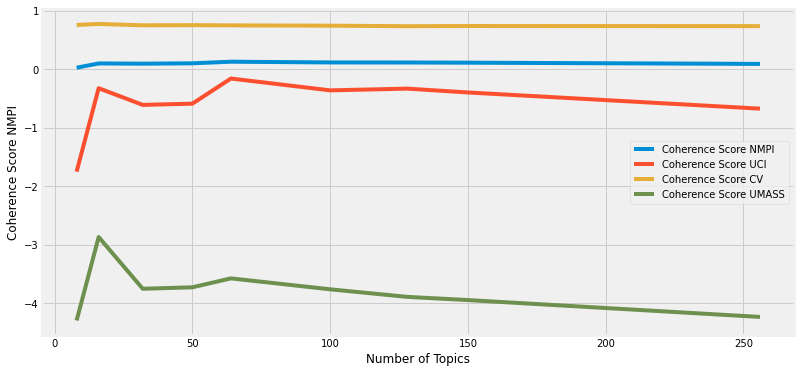

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

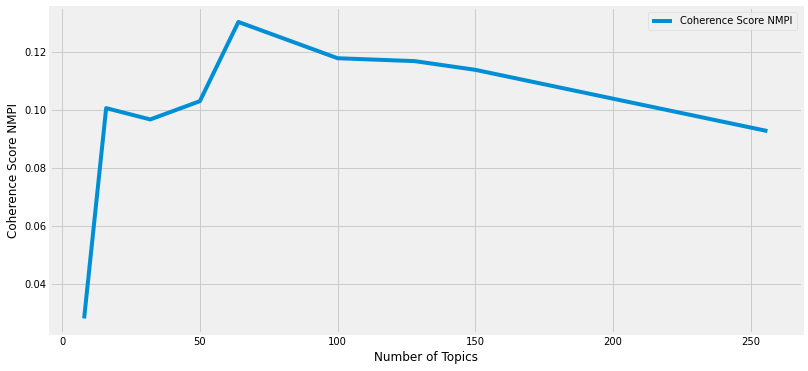

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

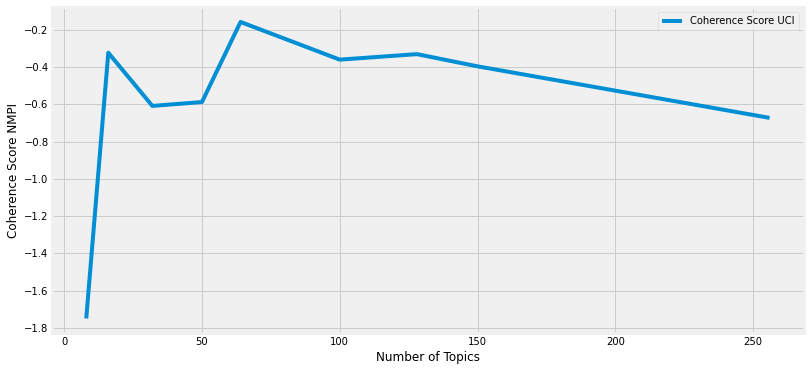

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
#plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

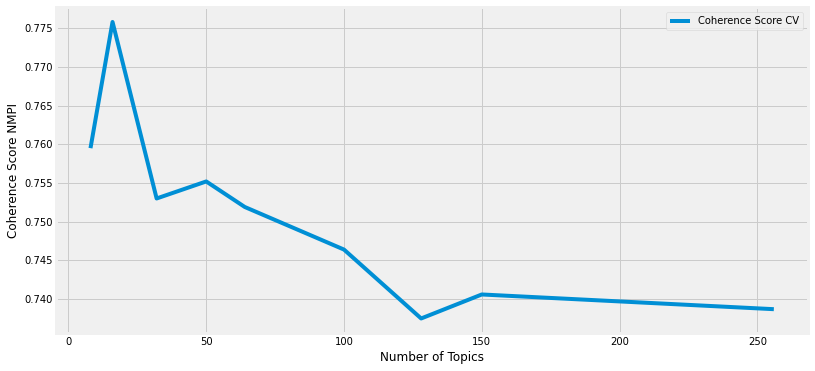

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
#plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

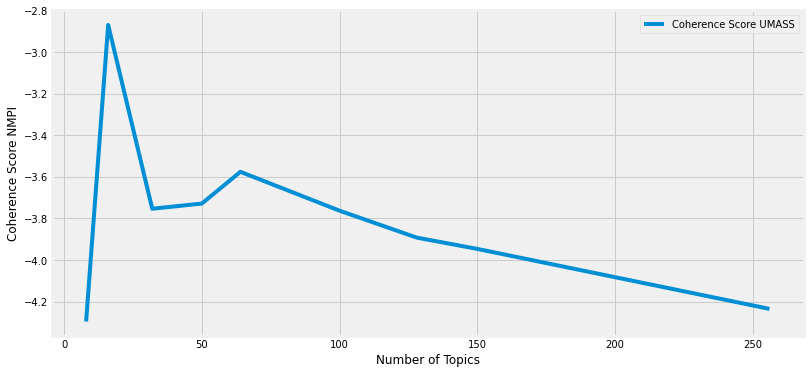

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
#plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

In [ ]:
lda.perplexity

560.0328193380594

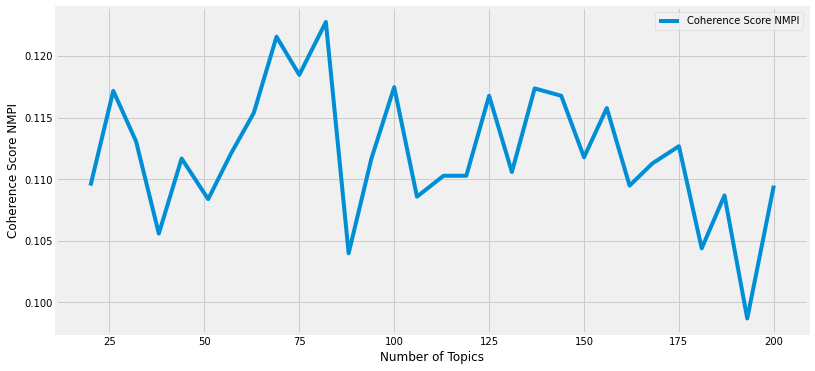

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

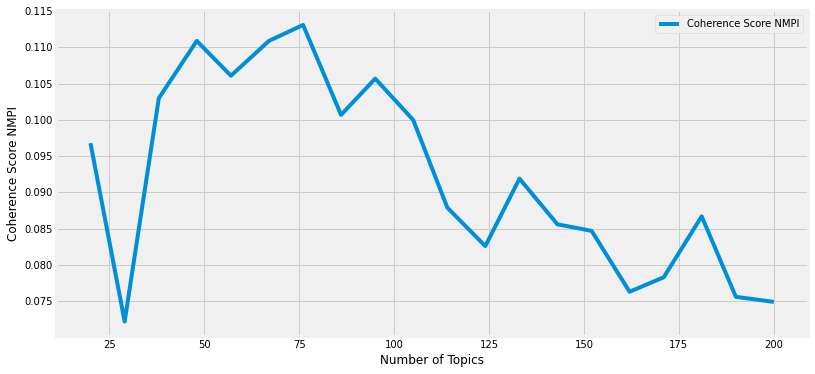

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

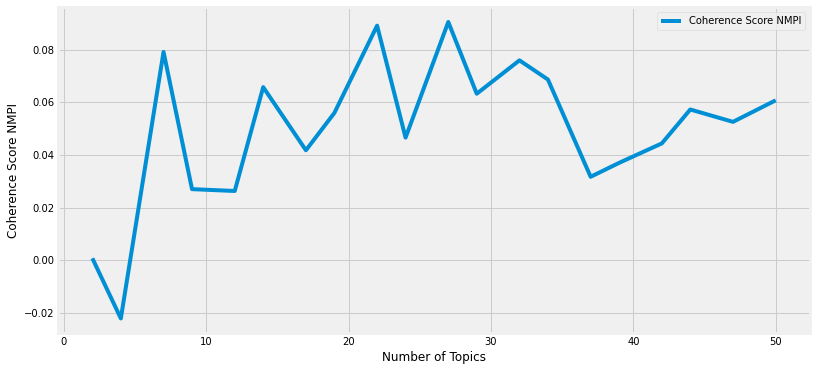

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

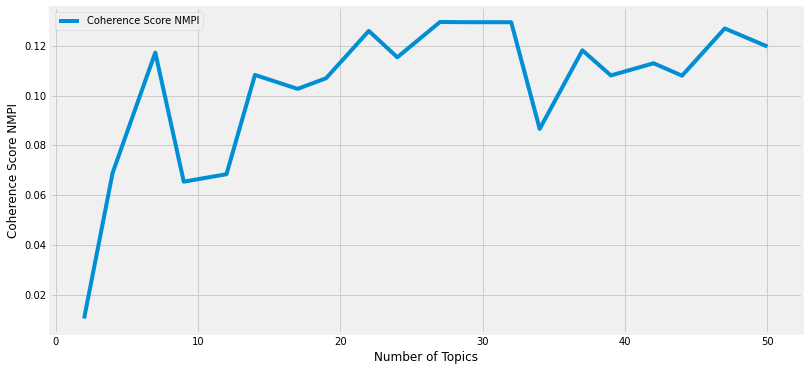

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# coherence_scores = list(topics_coherence_dist.values())


x_ax = K_values
y_ax = coherence_df.iloc[:, 3]
plt.figure(figsize=(12, 6))
plt.plot(x_ax, coherence_df.iloc[:, 1], label = coherence_df.columns[1])
#plt.plot(x_ax, coherence_df.iloc[:, 2], label = coherence_df.columns[2])
#plt.plot(x_ax, coherence_df.iloc[:, 3], label = coherence_df.columns[3])
#plt.plot(x_ax, coherence_df.iloc[:, 4], label = coherence_df.columns[4])

# plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score NMPI')
plt.legend()

## Saving The Topics

In [ ]:
best_lda = lda
best_lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 11388 docs, 496509 words
| Total Vocabs: 32951, Used Vocabs: 3685
| Entropy of words: 7.18779
| Entropy of term-weighted words: 7.18779
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.47679
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 64 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02424421 0.

In [ ]:
model_path = os.path.join(PATH, "models", "issues_lda.bin")
mapping_path = os.path.join(PATH, "models", "repo_issue.csv")


docs = best_lda.docs
topics_dist, ll = best_lda.infer(docs) 

best_lda.save(model_path)

In [ ]:
# len(set(issues_idx)), len(issues_idx)
# issues_idx

In [ ]:
i=0
mapping_df = pd.DataFrame()
for d in iter(best_lda.docs):
  topic = np.argmax(best_lda.infer(d)[0])
  # if issues_idx[i] is iter and len(issues_idx[i]) > 0:
    # print(issues_idx[i])
  issue = norm_issues_idx[i]
  i += 1
  mapping_df = mapping_df.append({'issue':issue, 'topic':topic}, ignore_index =True)

In [ ]:
best_lda.k

64

In [ ]:
# mapping_df[mapping_df['issue'].duplicated()].sort_values("issue")
mapping_df['issue'].drop_duplicates()
# mapping_df['issue']

0            4.0
1            5.0
2            7.0
3            8.0
4           12.0
          ...   
11383    46956.0
11384    46957.0
11385    46959.0
11386    46961.0
11387    46963.0
Name: issue, Length: 11388, dtype: float64

In [ ]:
mapping_df = mapping_df.astype(int)

mapping_df.shape[0], len(mapping_df['issue'].unique())

(11388, 11388)

Save the mapping to the disk

In [ ]:
mapping_df.to_csv(mapping_path, index = None)

In [ ]:
Counter(issues.loc[mapping_df[mapping_df['topic'] ==1]['issue']]['repository_url'])

Counter({'"https://api.github.com/repos/CM2Walki/CSGO"': 1,
         '"https://api.github.com/repos/LeonBlade/PaisleyPark"': 1,
         '"https://api.github.com/repos/MajeurAndroid/android-applications-info"': 1,
         '"https://api.github.com/repos/Tai7sy/vs-obfuscation"': 1,
         '"https://api.github.com/repos/ViaVersion/ViaRewind"': 185,
         '"https://api.github.com/repos/hapijs/basic"': 1,
         '"https://api.github.com/repos/kazu-yamamoto/logger"': 1,
         '"https://api.github.com/repos/notanumber/xapian-haystack"': 1,
         '"https://api.github.com/repos/nvonahsen/jitsi-token-moderation-plugin"': 1,
         '"https://api.github.com/repos/olofd/react-native-signalr"': 4,
         '"https://api.github.com/repos/omaralvarez/deluge-autoremoveplus"': 1,
         '"https://api.github.com/repos/rrweb-io/rrweb-snapshot"': 1,
         '"https://api.github.com/repos/smith-j-travis/MinecraftAutoClicker"': 3,
         '"https://api.github.com/repos/streamroot/videojs-

Load Topic model from disk

In [ ]:
tt = tp.LDAModel.load(model_path)
tt.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 11388 docs, 496509 words
| Total Vocabs: 32951, Used Vocabs: 3685
| Entropy of words: 7.18779
| Entropy of term-weighted words: 7.18779
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.49243
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 64 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02397746 0.

In [ ]:
tt.perplexity

660.1240283204631

## HDP Model

In [ ]:
lda= tp.HDPModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top)

v, dt, average_coherence = model_pipeline(lda, norm_issues)

Num issues: 1377 , Vocab size: 7972 , Num words: 57853
Removed top words: ['java', 'use']


In [ ]:
lda.k

157

In [ ]:
average_coherence

{'c_npmi': 0.03627638242886714,
 'c_uci': -3.255849020286714,
 'c_v': 0.8651701647384911,
 'u_mass': -6.32518388774991}

In [ ]:
lda.ll_per_word

-7.321268802409177

In [ ]:
lda= tp.HLDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top)

v, dt, average_coherence = model_pipeline(lda, norm_issues)

Num issues: 9544 , Vocab size: 26237 , Num words: 346609
Removed top words: ['use', 'add']


In [ ]:
average_coherence

{'c_npmi': 0.07227107996204721,
 'c_uci': -1.437556026572817,
 'c_v': 0.8469153700768947,
 'u_mass': -6.791604189554706}

In [ ]:
lda.k

20

## Pseudo-document LDA

In [ ]:
pdm = tp.PTModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=K, p = 10*K)


v, dt = model_pipeline(pdm, norm_issues)
v.display(dt)

Num docs: 412 , Vocab size: 1416 , Num words: 20290
Removed top words: ['looking', 'file', 'http', 'found', 'gulp']
Iteration: 0	Log-likelihood: -7.163525376935614
Iteration: 10	Log-likelihood: -6.290975949657322
Iteration: 20	Log-likelihood: -6.254786471235981
Iteration: 30	Log-likelihood: -6.226937102069991
Iteration: 40	Log-likelihood: -6.2194346590647855
Iteration: 50	Log-likelihood: -6.217781736365735
Iteration: 60	Log-likelihood: -6.218501426574043
Iteration: 70	Log-likelihood: -6.21329296255946
Iteration: 80	Log-likelihood: -6.211321290779607
Iteration: 90	Log-likelihood: -6.21376434974097
Iteration: 100	Log-likelihood: -6.214262933214642
Iteration: 110	Log-likelihood: -6.21170110194891
Iteration: 120	Log-likelihood: -6.212045637843878
Iteration: 130	Log-likelihood: -6.213439884930188
Iteration: 140	Log-likelihood: -6.208924220893817
Iteration: 150	Log-likelihood: -6.209519361071894
Iteration: 160	Log-likelihood: -6.209438004026335
Iteration: 170	Log-likelihood: -6.2047146543662

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Word Cloud

### Backend Scripts

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def topics_to_wordclouds(model, topic_dict, save=False):
    '''Wrapper function that generates wordclouds for ALL topics of a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_dic: dict -> per topic, an arrays with top words and associated frequencies
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots
    '''
    
    wcloud = WordCloud(background_color="white")
    fig, ax = plt.subplots(1, 3, figsize=(15,4))

    cnt=0
    for k, arr in topic_dict.items():
        
        create_wordcloud(model, k, fig, ax[cnt], save)
        ax[cnt].title.set_text("Topic # " + str(k))
        cnt+=1
        
        if cnt==3:
            cnt=0
            fig, ax = plt.subplots(1, 3, figsize=(15,4))
    
    
              

def create_wordcloud(model, topic_idx, fig, ax, save=False):
    '''Wrapper function that generates individual wordclouds from topics in a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_idx: int -> topic index
    fig, ax: obj -> pyplot objects from subplots method
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots'''
    wcloud = WordCloud(background_color='white')
    
    topic_freqs = dict(model.get_topic_words(topic_idx))
    
    img = wcloud.generate_from_frequencies(topic_freqs)
    
    ax.imshow(img, interpolation='bilinear')
    ax.axis('off')
    
    if save:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        img_name = "wcloud_topic_" + str(topic_idx) +'.png'
        plt.savefig(''.join(['imgs/',img_name]), bbox_inches=extent.expanded(1.1, 1.2))

In [ ]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_topics_top_words(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        #if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

### Vanilla LDA - Word Cloud

1. Topics of issues of the same pattern
2. Topics of issues of the different patterns

In [ ]:
#best_lda = lda
topics_top_words = get_topics_top_words(best_lda, top_n=10)
topics_to_wordclouds(best_lda, topics_top_words)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 11388 docs, 496509 words
| Total Vocabs: 32951, Used Vocabs: 3685
| Entropy of words: 7.18779
| Entropy of term-weighted words: 7.18779
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.47679
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 64 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02424421 0.

In [ ]:
#lda = best_lda

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=0, min_df=0, max_len=5, max_cand=10000)
cands = extractor.extract(best_lda)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(best_lda, cands, min_df=0, smoothing=1e-2, mu=0.25)
for k in range(best_lda.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in best_lda.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: polymer, condenses, outcome, paper, iron
animation	0.05641420558094978
route	0.05440545082092285
page	0.052564091980457306
app	0.04168333485722542
src	0.03984197601675987
alt	0.032643936574459076
img	0.03197435289621353
width	0.029296014457941055
neon	0.026282882317900658
html	0.02293495647609234

== Topic #1 ==
Labels: viaversion, viarewind, viabackwards, bungeecord, checklist
server	0.08657010644674301
error	0.04703366383910179
client	0.04012581333518028
player	0.03321795538067818
reproduce	0.029543565586209297
issue	0.029249614104628563
version	0.025575224310159683
viaversion	0.021165955811738968
crash	0.019696200266480446
bug	0.018667371943593025

== Topic #2 ==
Labels: homeassistant, coro, jsonpayloadtosend, clientsock, recvfrom
component	0.03310210257768631
entity	0.02723335288465023
gree	0.02559010311961174
homeassistant	0.022773101925849915
py	0.020895101130008698
climate	0.020895101130008698
nest	0.020425602793693542
temp	0.019956102594733238
id	0.019956

Anomaly 1: ElasticSearch configuration


Anomaly 2: Maven configuration